In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%pylab inline
import datetime, time
import requests
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Config

In [2]:
symbol = "XMRETH"  # Converted into XMRUSDT
conversion_symbol = "ETHUSDT"
period = 200
interval = "6h"
delta = 0.04

## Data retrieval 

In [3]:
y_data = []
start_prices = []
amplitude = []
days = list(np.arange(period,-30,-30))
for i, day in enumerate(days):
    if i == len(days)-1:
        continue
    start = datetime.datetime.now() - datetime.timedelta(days=float(day))
    start = int(time.mktime(start.timetuple())*1e3 + start.microsecond/1e3)
    end = datetime.datetime.now() - datetime.timedelta(days=float(days[i+1]))
    end = int(time.mktime(end.timetuple())*1e3 + end.microsecond/1e3)
    print(start,end)
    print(datetime.datetime.fromtimestamp(int(str(start)[:-3])).strftime('%Y-%m-%d'),
          datetime.datetime.fromtimestamp(int(str(end)[:-3])).strftime('%Y-%m-%d')) 
    r = requests.get("https://api.binance.com/api/v1/klines?symbol={}&interval={}&startTime={}&endTime={}".format(
    symbol, interval, start, end))
    r = r.json()
    n = requests.get("https://api.binance.com/api/v1/klines?symbol={}&interval={}&startTime={}&endTime={}".format(
    conversion_symbol, interval, start, end))
    n = n.json()
    counter = 0
    for array in r:
        ethaverage = np.average([float(n[counter][2]), float(n[counter][3])])
        y_data.append(np.average([float(array[2]), float(array[3])])*ethaverage)
        # print("ETH Average = ", ethaverage, "  ", counter)
        # print("XMR Average = ", np.average([float(array[2]), float(array[3])])*ethaverage)
        start_prices.append(float(array[1])*ethaverage)
        amplitude.append((float(array[2])-float(array[3]))*ethaverage)
        counter += 1
x_data = np.array(list(range(len(y_data))))

1512954548149 1515546548149
2017-12-10 2018-01-09
1515546549736 1518138549736
2018-01-09 2018-02-08
1518138550380 1520730550380
2018-02-08 2018-03-10
1520730551086 1523318951086
2018-03-10 2018-04-09
1523318951862 1525910951862
2018-04-09 2018-05-09
1525910953182 1528502953182
2018-05-09 2018-06-08
1528502953872 1531094953872
2018-06-08 2018-07-08


## Pseudo-renko

In [4]:
pre = y_data[0] # first datapoint
increment = 0

x_positive = []
y_positive = []
x_negative = []
y_negative = []

# generate delta% change points
for i, point in enumerate(y_data):
    increment += point-pre
    increment_perc = increment/pre
    pre = point
    if increment_perc > delta:
        x_positive.append(i)
        y_positive.append(point)
        increment = 0
    if increment_perc < -delta:
        x_negative.append(i)
        y_negative.append(point)
        increment = 0

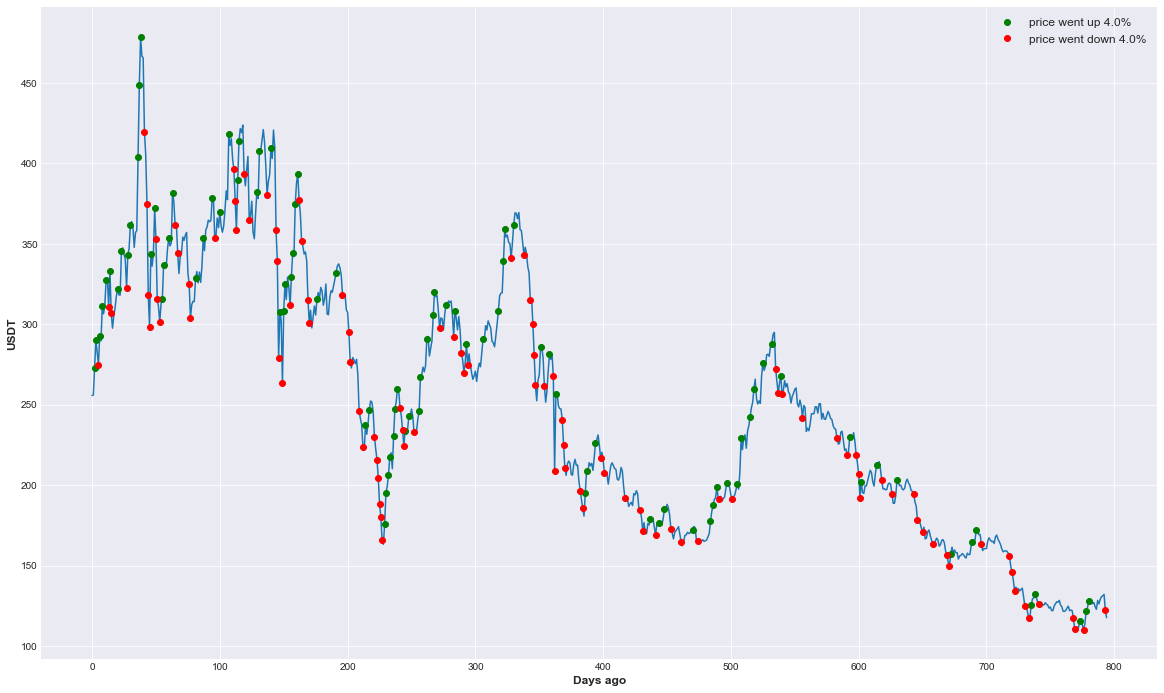

In [5]:
plt.figure(figsize=(20,12))
plt.plot(x_data, y_data, "-")
plt.plot(x_positive, y_positive, "o", color="green", label="price went up {}%".format(delta*100))
plt.plot(x_negative, y_negative, "o", color="red", label="price went down {}%".format(delta*100))
plt.ylabel("USDT", fontsize=12, fontweight=600)
plt.xlabel("Days ago", fontsize=12, fontweight=600)
plt.legend(fontsize=12)

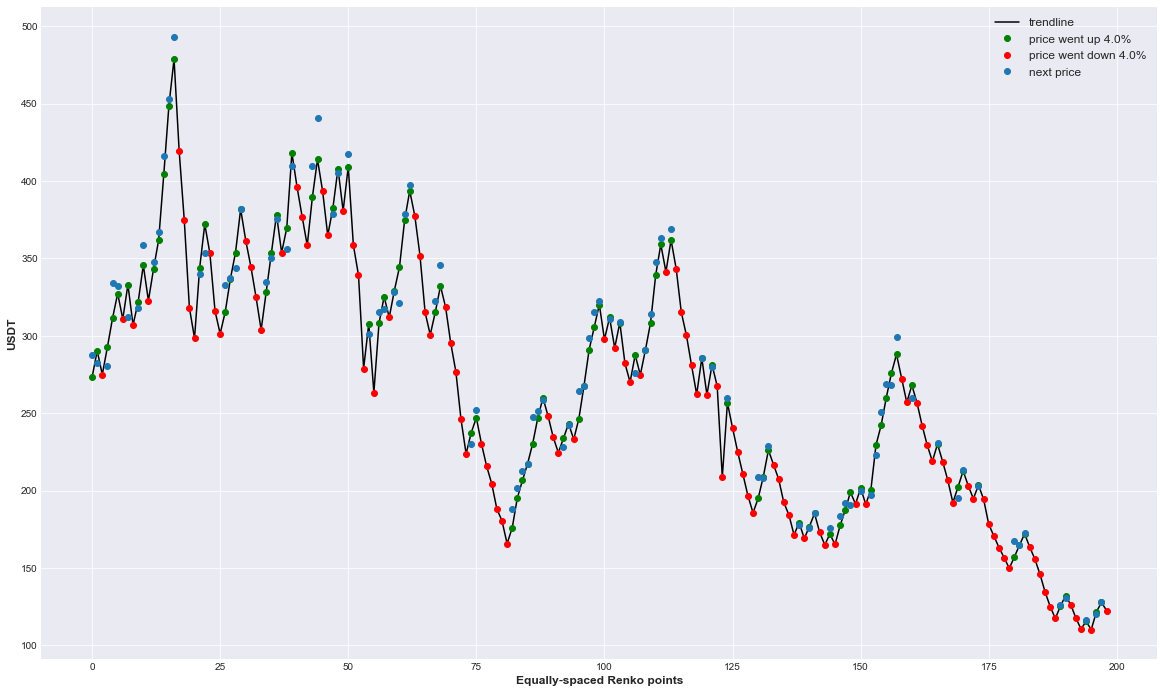

In [6]:
# regular plot
plt.figure(figsize=(20,12))
x_positive_regular = []
x_negative_regular = []
y_data_regular = []
nextprice_positive_regular = []
nextprice_negative_regular = []
amplitude_positive_regular = []
amplitude_negative_regular = []
counter = 0
for i in x_data:
    if i in x_positive:
        x_positive_regular.append(counter)
        y_data_regular.append(y_positive[np.argwhere(np.array(x_positive)==i)[0][0]])
        nextprice_positive_regular.append(start_prices[i+1])
        amplitude_positive_regular.append(amplitude[i])
        counter += 1
    elif i in x_negative:
        x_negative_regular.append(counter)
        y_data_regular.append(y_negative[np.argwhere(np.array(x_negative)==i)[0][0]])
        nextprice_negative_regular.append(start_prices[i+1])
        amplitude_negative_regular.append(amplitude[i])
        counter += 1
x_data_regular = list(range(counter))

plt.plot(x_data_regular, y_data_regular, '-', color="black", label="trendline")
plt.plot(x_positive_regular, y_positive, "o", color="green", label="price went up {}%".format(delta*100))
plt.plot(x_negative_regular, y_negative, "o", color="red", label="price went down {}%".format(delta*100))
plt.ylabel("USDT", fontsize=12, fontweight=600)
plt.xlabel("Equally-spaced Renko points", fontsize=12, fontweight=600)

plt.plot(x_positive_regular, nextprice_positive_regular, "o", label="next price")

plt.legend(fontsize=12)

## Trading algo

In [7]:
# params
budget = 100 # Ethereum
min_steps = 1

### baseline (holding)

In [8]:
init_holding = budget/y_data[0] #xmr
end_holding = init_holding*y_data[-1] #euro
print(end_holding)
print(init_holding)

46.01462741157322
0.3910342299233037


### renko

In [9]:
eth = 0
xmr = budget/y_data[0]
uptrend = 0
downtrend = 0
cur_price = y_data[0]
buy_x = []
buy_y = []
sell_x = []
sell_y = []
y_data_regular = []
holding_value = []
algo_value = []
buy_sell_steps = 0
eth_progression = []
hold_progression = []
amplitude_progression = []
N_amp = 12
amplitude_threshold = 100000000
for point in x_data_regular:
    
    # assign trend
    if point in x_positive_regular:
        uptrend += 1
        downtrend = 0
        cur_price = y_positive[np.argwhere(np.array(x_positive_regular)==point)[0][0]]
        cur_amplitude = amplitude_positive_regular[np.argwhere(np.array(x_positive_regular)==point)[0][0]]
        next_price = nextprice_positive_regular[np.argwhere(np.array(x_positive_regular)==point)[0][0]]
        y_data_regular.append(cur_price)
        
    elif point in x_negative_regular:
        downtrend += 1
        uptrend = 0
        cur_price = y_negative[np.argwhere(np.array(x_negative_regular)==point)[0][0]]
        cur_amplitude = amplitude_negative_regular[np.argwhere(np.array(x_negative_regular)==point)[0][0]]
        next_price = nextprice_negative_regular[np.argwhere(np.array(x_negative_regular)==point)[0][0]]
        y_data_regular.append(cur_price)
        
        

    # buy
    amplitude_progression.append(cur_amplitude)
    last_amp = np.convolve(amplitude_progression, np.ones((N_amp,))/N_amp, mode='valid')[-1]
    if uptrend == min_steps:
        # uptrend = 0
        # downtrend = 0
        #print("uptrend", cur_price)
        buy_sell_steps +=1
        if eth > 0 and last_amp < amplitude_threshold:
            xmr = (eth*0.999)/next_price
            eth = 0
            #print("{}\t{}\t{}".format(round(cur_price,2), round(xmr,4), round(eth,2)))
            hold_progression.append((budget/y_data[0])*next_price)
            eth_progression.append(xmr*next_price)
            buy_x.append(point)
            buy_y.append(next_price)
        
    # sell
    elif downtrend == min_steps:
        buy_sell_steps +=1
        if xmr > 0 and last_amp < amplitude_threshold:
            eth = (xmr*0.999)*next_price
            xmr = 0
            #print("{}\t{}\t{}".format(round(cur_price,2), round(xmr,4), round(eth,2)))
            hold_progression.append((budget/y_data[0])*next_price)
            eth_progression.append(eth)
            sell_x.append(point)
            sell_y.append(next_price)
    else:
        hold_progression.append((budget/y_data[0])*next_price)
        
        if xmr > 0:
            eth_progression.append(xmr*next_price)
        elif eth > 0:
            eth_progression.append(eth)
    
    # algo value
    if eth > 0:
        algo_value.append(eth)
    elif xmr > 0:
        algo_value.append(xmr*next_price)
        
    # holding value
    holding_value.append(init_holding*next_price)
        
end_eth = max(eth, xmr*next_price)
print("USDT final:\t {}".format(round(end_eth,2)))
print("Gain respect baseline:\t {}%".format(round((end_eth/end_holding)*100)))

ETH final:	 155.94
Gain respect baseline:	 339.0%


In [10]:
# moving average amplitude
amp_raw = [t/0.5 for t in amplitude_progression] # I reduce amplitude arbitrarily to fit in the plot scale
amp = np.convolve(amp_raw, np.ones((N_amp,))/N_amp, mode='full')

Text(0,0.5,'USDT for every 100 USDT invested')

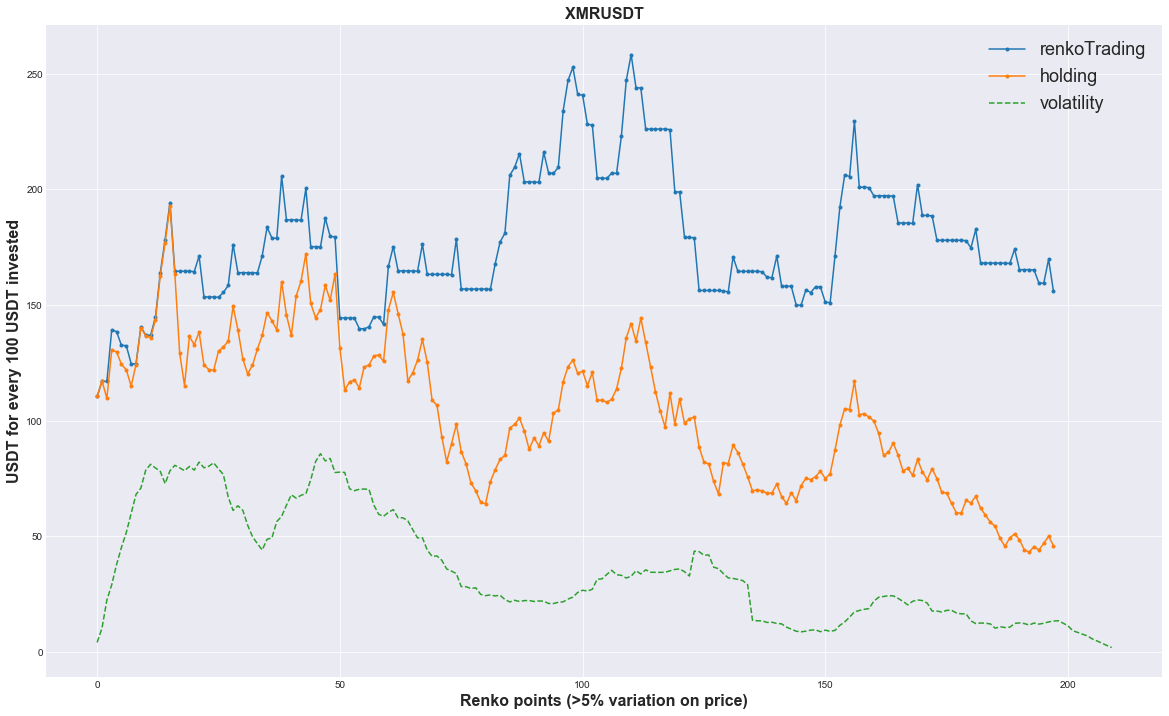

In [11]:
plt.figure(figsize=(20,12))
plt.plot(eth_progression, ".-", label="renkoTrading")
plt.plot(hold_progression, ".-", label="holding")
plt.plot(amp, "--", label="volatility")
plt.legend(fontsize=18)
plt.title("XMRUSDT", fontsize=16, fontweight=600)
plt.xlabel("Renko points (>5% variation on price)", fontsize=16, fontweight=600)
plt.ylabel("USDT for every {} USDT invested".format(budget), fontsize=16, fontweight=600)

Text(0,0.5,'USDT')

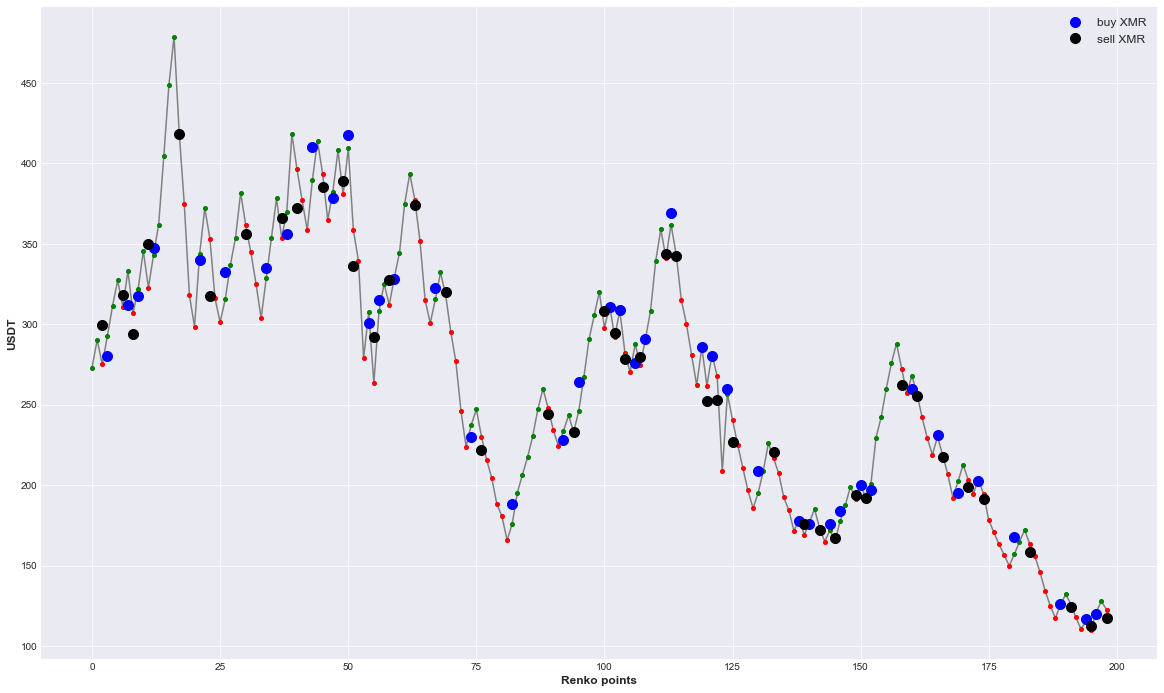

In [12]:
plt.figure(figsize=(20,12))
plt.plot(x_data_regular, y_data_regular, '-', color="grey")
plt.plot(x_positive_regular, y_positive, "o", color="green", markersize=4)
plt.plot(x_negative_regular, y_negative, "o", color="red", markersize=4)
plt.plot(buy_x, buy_y, "o", color="blue", markersize=10, label="buy XMR")
plt.plot(sell_x, sell_y, "o", color="black", markersize=10, label="sell XMR")
plt.legend(fontsize=12)
plt.xlabel("Renko points", fontsize=12, fontweight=600)
plt.ylabel("USDT", fontsize=12, fontweight=600)